# ANLI with LLM

You have to implement in this notebook a better ANLI classifier using an LLM.
This classifier must be implemented using DSPy.


In [ ]:
import os
import dspy
from typing import Literal
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import evaluate
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Any


os.environ["XAI_API_KEY"] = ""

lm = dspy.LM('xai/grok-3-mini', api_key=os.environ['XAI_API_KEY'])
dspy.configure(lm=lm)

## Load ANLI dataset

In [3]:
dataset = load_dataset("facebook/anli")
dataset = dataset.filter(lambda x: x['reason'] != None and x['reason'] != "")

## Evaluate Metrics

Let's use the huggingface `evaluate` package to compute the performance of the baseline.


In [4]:
from evaluate import load

accuracy = load("accuracy")
precision = load("precision")
recall = load("recall")
f1 = load("f1")


In [5]:
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

### DSPy Signatures and Modules 

In [6]:
class JointPromptSignature(dspy.Signature):
    """Generate both an explanation and a label for the NLI task in one step."""
    premise = dspy.InputField()
    hypothesis = dspy.InputField()
    explanation = dspy.OutputField(desc="Explanation of the relationship between premise and hypothesis.")  
    label: Literal['entailment', 'neutral', 'contradiction'] = dspy.OutputField()

class PipelineExplanationSignature(dspy.Signature):
    """Generate an explanation for the relationship between premise and hypothesis."""
    premise = dspy.InputField()
    hypothesis = dspy.InputField()
    explanation = dspy.OutputField(desc="Explanation of the relationship between premise and hypothesis.")  

class PipelineResponseSignature(dspy.Signature):
    """Given an explanation, determine the entailment label."""
    premise = dspy.InputField()
    hypothesis = dspy.InputField()
    explanation = dspy.InputField(desc="Explanation of the relationship between premise and hypothesis.")
    label: Literal['entailment', 'neutral', 'contradiction'] = dspy.OutputField()

class PipelineModule(dspy.Module):
    def __init__(self):
        super().__init__()
        self.explanation_step = dspy.ChainOfThought(PipelineExplanationSignature)
        self.label_step = dspy.Predict(PipelineResponseSignature)
    
    def forward(self, premise, hypothesis):
        explanation_result = self.explanation_step(
            premise=premise, 
            hypothesis=hypothesis 
        )
        label_result = self.label_step(premise=premise, hypothesis=hypothesis, explanation=explanation_result.explanation)

        return dspy.Prediction(
            explanation=explanation_result.explanation,
            label=label_result.label
        )

# Initialize modules
print("Initializing modules...")
joint_cot = dspy.ChainOfThought(JointPromptSignature)
pipeline_module = PipelineModule()
print("✓ Modules initialized")



Initializing modules...
✓ Modules initialized


### Prepare Data for Evaluation

In [7]:
def create_dspy_examples(dataset: List[Dict[str, Any]]) -> List[dspy.Example]:
    """
    Convert dataset to dspy.Example instances including the 'reason' field.
    The 'reason' field will be stored in the example but won't be visible to the LLM
    since it's not included in the signatures.
    """
    examples = []
    for item in dataset:
        if item.get('reason') and item['reason'].strip() != '':
            # Create dspy.Example with all fields including 'reason'
            example = dspy.Example(
                premise=item['premise'],
                hypothesis=item['hypothesis'],
                label=item['label'],
                reason=item['reason']
            ).with_inputs('premise', 'hypothesis')
            
            examples.append(example)
    return examples

In [8]:
# Load evaluation dataset (using dev_r3 for testing)
print("Loading dev_r3 dataset...")
dev_dataset = load_dataset("anli", split="dev_r3")
# Filter examples with reasons
dev_with_reasons = [ex for ex in dev_dataset if ex.get('reason') and ex['reason'].strip() != '']
print(f"Found {len(dev_with_reasons)} examples with reasons out of {len(dev_dataset)} total")

Loading dev_r3 dataset...
Found 1200 examples with reasons out of 1200 total


In [9]:
# Convert evaluation samples to dspy.Example instances
dspy_eval_samples = create_dspy_examples(dev_with_reasons)

# Create a mapping from (premise, hypothesis) to reason so we can access reason in refine module wihout passing it to the LLM
REASON_MAP = {}

for ex in dspy_eval_samples:
    if isinstance(ex, dict):
        key = (ex['premise'], ex['hypothesis'])
        REASON_MAP[key] = ex.get('reason', '')
    else:  # dspy.Example
        key = (ex.premise, ex.hypothesis)
        REASON_MAP[key] = ex.get('reason', '')

### Similarity Analysis

In [10]:
similarity_model = SentenceTransformer("all-MiniLM-L6-v2")

def compute_similarity_scores(premise, hypothesis, human_reason, predicted_explanation):
    """
    Compute similarity scores between different text combinations.
    Returns a dictionary with all possible combinations.
    """
    # Combine premise and hypothesis
    premise_hypothesis = f"{premise} {hypothesis}"
    
    # Encode all texts
    texts = [premise_hypothesis, human_reason, predicted_explanation]
    embeddings = similarity_model.encode(texts)
    
    # Compute similarities
    similarities = similarity_model.similarity(embeddings, embeddings).numpy()
    
    # Extract individual similarities
    ph_hr_sim = similarities[0, 1]  # premise+hypothesis vs human_reason
    ph_pe_sim = similarities[0, 2]  # premise+hypothesis vs predicted_explanation
    hr_pe_sim = similarities[1, 2]  # human_reason vs predicted_explanation
    
    # Handle division by zero
    def safe_divide(a, b):
        return a / b if b != 0 else 0
    
    return {
        'A': ph_hr_sim,  # (premise, hypothesis) vs human_reason
        'B': hr_pe_sim,  # human_reason vs predicted_explanation
        'C': ph_pe_sim,  # (premise, hypothesis) vs predicted_explanation
        'A/B': safe_divide(ph_hr_sim, hr_pe_sim),
        'A/C': safe_divide(ph_hr_sim, ph_pe_sim),
        'B/C': safe_divide(hr_pe_sim, ph_pe_sim)
    }



In [11]:
def create_similarity_histograms(results, approach_name):
    """
    Create histograms for each similarity metric comparing correct vs incorrect predictions.
    """
    # Convert results to DataFrame for easier analysis
    df = pd.DataFrame(results)
    
    # Separate correct and incorrect predictions
    correct_df = df[df['is_correct'] == True]
    incorrect_df = df[df['is_correct'] == False]
    
    # Define metrics to plot
    metrics = ['A', 'B', 'C', 'A/B', 'A/C', 'B/C']
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'{approach_name} - Similarity Metrics Distribution: Correct vs Incorrect Predictions', fontsize=16)
    axes = axes.flatten()
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        
        # Get data for correct and incorrect predictions
        correct_values = correct_df[metric].values
        incorrect_values = incorrect_df[metric].values
        
        # Determine range for histogram bins
        all_values = np.concatenate([correct_values, incorrect_values])
        min_val, max_val = np.min(all_values), np.max(all_values)
        
        # Create bins
        if metric in ['A', 'B', 'C']:  # Similarity scores are between 0 and 1
            bins = np.linspace(0, 1, 21)  # 20 bins from 0 to 1
        else:  # Ratio metrics can have wider range
            bins = np.linspace(min_val, max_val, 21)
        
        # Plot histograms
        ax.hist(correct_values, bins=bins, alpha=0.7, label='Correct', color='green', edgecolor='black')
        ax.hist(incorrect_values, bins=bins, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
        
        # Add labels and title
        ax.set_xlabel(f'{metric} Score')
        ax.set_ylabel('Count')
        ax.set_title(f'Metric {metric}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        correct_mean = np.mean(correct_values) if len(correct_values) > 0 else 0
        incorrect_mean = np.mean(incorrect_values) if len(incorrect_values) > 0 else 0
        ax.text(0.05, 0.95, f'Correct μ: {correct_mean:.3f}\nIncorrect μ: {incorrect_mean:.3f}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    return fig

### Evaluation Functions

In [12]:
from dspy.evaluate import Evaluate

def create_evaluator_metric(module, collect_similarity=False):
    """Create a metric function compatible with dspy.Evaluate"""
    LABEL_MAP = {'entailment': 0, 'neutral': 1, 'contradiction': 2}
    results_collector = [] if collect_similarity else None
    
    def metric(example, prediction, trace=None):
        # Handle the case where prediction might be the module output
        if hasattr(prediction, 'label'):
            pred_label = prediction.label
            pred_explanation = prediction.explanation
        else:
            # If not, run the module
            pred = module(premise=example.premise, hypothesis=example.hypothesis)
            pred_label = pred.label
            pred_explanation = pred.explanation
        
        # Convert labels
        pred_label_int = LABEL_MAP.get(pred_label.lower().strip(), -1)
        true_label = example.label
        
        is_correct = pred_label_int == true_label
        
        # Collect similarity scores if requested
        if collect_similarity and hasattr(example, 'reason') and example.reason:
            sim_scores = compute_similarity_scores(
                premise=example.premise,
                hypothesis=example.hypothesis,
                human_reason=example.reason,
                predicted_explanation=pred_explanation
            )
            results_collector.append({
                'premise': example.premise,
                'hypothesis': example.hypothesis,
                'true_label': true_label,
                'predicted_label': pred_label,
                'human_reason': example.reason,
                'predicted_explanation': pred_explanation,
                'is_correct': is_correct,
                **sim_scores
            })
        
        return is_correct
    
    return metric, results_collector

def evaluate_with_similarity_parallel(module, dataset, num_threads=4, collect_results=False):
    """
    Parallel evaluation using dspy.Evaluate while maintaining similarity analysis
    """
    # Create metric function and results collector
    metric_fn, results_collector = create_evaluator_metric(module, collect_results)
    
    # Filter dataset for examples with reasons
    filtered_dataset = []
    for ex in dataset:
        if isinstance(ex, dspy.Example) and hasattr(ex, 'reason') and ex.reason:
            filtered_dataset.append(ex)
        elif isinstance(ex, dict) and ex.get('reason'):
            # Convert dict to dspy.Example if needed
            filtered_dataset.append(dspy.Example(**ex).with_inputs('premise', 'hypothesis'))
    
    # Run parallel evaluation
    evaluator = Evaluate(
        devset=filtered_dataset,
        metric=metric_fn,
        num_threads=num_threads,
        display_progress=True,
        display_table=0
    )
    
    accuracy = evaluator(module)
    
    return accuracy, results_collector if collect_results else []


### Evaluate Basic Modules 

In [13]:
joint_accuracy, joint_results = evaluate_with_similarity_parallel(
    joint_cot,
    dspy_eval_samples[:200],
    num_threads=4,
    collect_results=True
)
print(f"Joint CoT Accuracy: {joint_accuracy:.3f}")

Average Metric: 147.00 / 200 (73.5%): 100%|██████████| 200/200 [03:14<00:00,  1.03it/s]

2025/08/03 16:36:24 INFO dspy.evaluate.evaluate: Average Metric: 147 / 200 (73.5%)



Joint CoT Accuracy: 73.500


In [14]:
pipeline_accuracy, pipeline_results = evaluate_with_similarity_parallel(
    pipeline_module,
    dspy_eval_samples[:200],
    num_threads=4,  
    collect_results=True
)
print(f"Pipeline Module Accuracy: {pipeline_accuracy:.3f}")

Average Metric: 149.00 / 200 (74.5%): 100%|██████████| 200/200 [01:22<00:00,  2.44it/s]

2025/08/03 16:37:46 INFO dspy.evaluate.evaluate: Average Metric: 149 / 200 (74.5%)



Pipeline Module Accuracy: 74.500


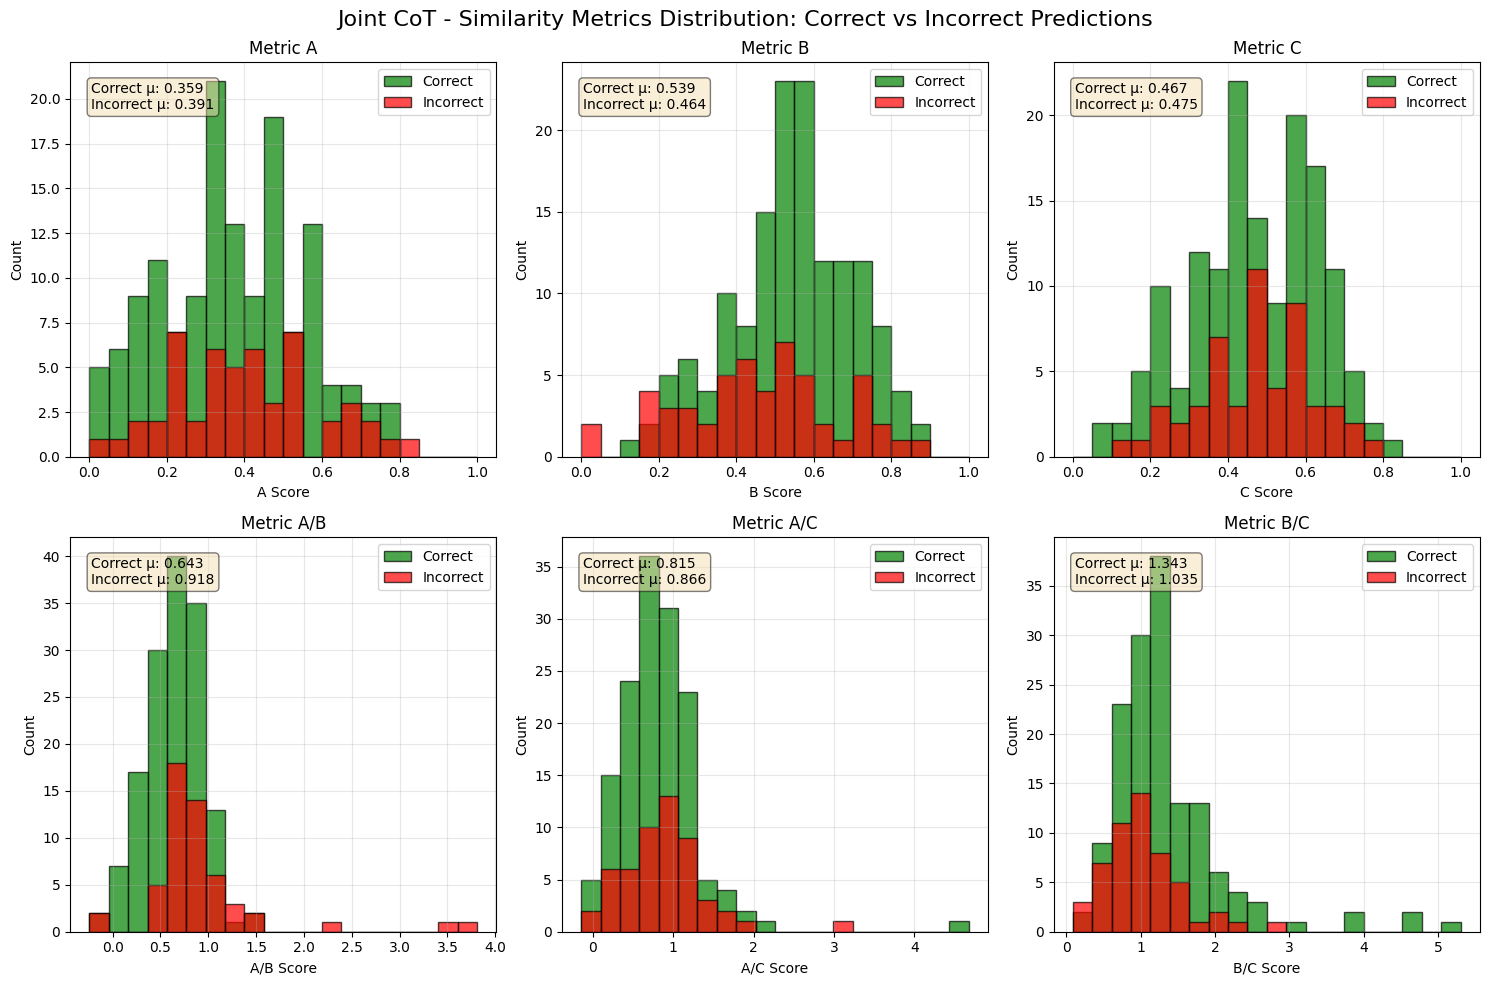

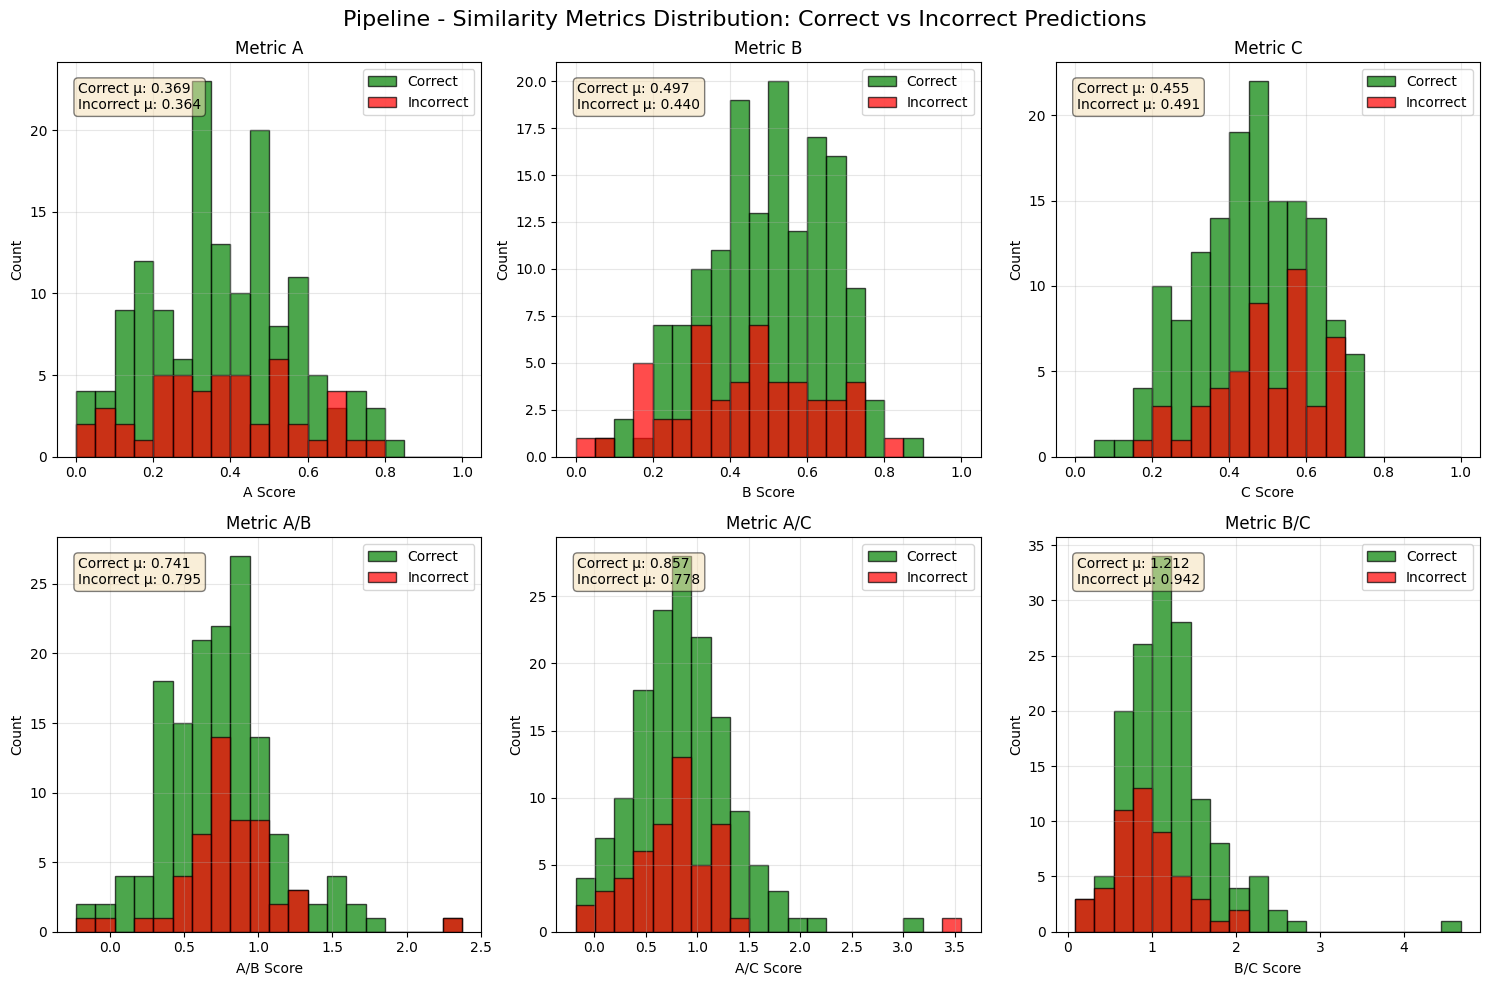

In [15]:
joint_fig = create_similarity_histograms(joint_results, "Joint CoT")
plt.show()

pipeline_fig = create_similarity_histograms(pipeline_results, "Pipeline")
plt.show()

### Observations 



#### Accuracy:

Joint CoT: 0.735

Pipeline: 0.745



#### Probable Ranges of Scores for Correct Label:

##### Joint CoT:

Metric A: 0.0 - 0.6 

Metric B: 0.45 - 0.85

Metric A/B: 0.0 - 1.25

Metric A/C: 0.0 - 1.25


##### Pipeline:

Metric A: 0.1 - 0.85

Metric B: 0.2 - 0.8

Metric A/B: 0.0 - 1.9

Metric B/C: over 0.5


### Adding the Refine Module with Similarity Thresholds

We designed the reward function for the Refine Modules by first performing a statistical analysis on the relationship between different similarity metrics and the performance of the model. We visualized the results using a histogram so that we could fine thresholds which we could use for our Refine Module. The reward function encouraged the model to stay within the thresholds of the where the model performed best. 

In [16]:
def joint_similarity_reward(example, pred: dspy.Prediction) -> float:
    key = (example['premise'], example['hypothesis'])
    reason = REASON_MAP.get(key, '')
    
    score = 0.0
    similarity_scores = compute_similarity_scores(
        example['premise'],     
        example['hypothesis'],  
        reason,
        pred.explanation
    )

    if 0.0 <= similarity_scores['A'] <= 0.6:
        score += 1.0
    if 0.45 <= similarity_scores['B'] <= 0.85:
        score += 1.0
    if 0.0 <= similarity_scores['A/B'] <= 1.25:
        score += 1.0
    if 0.0 <= similarity_scores['A/C'] <= 1.25:
        score += 1.0

    return score

def pipeline_similarity_reward(example, pred: dspy.Prediction) -> float:
    key = (example['premise'], example['hypothesis'])
    reason = REASON_MAP.get(key, '')

    score = 0.0
    similarity_scores = compute_similarity_scores(
        example['premise'],      
        example['hypothesis'],  
        reason, 
        pred.explanation
    )
    
    if 0.1 <= similarity_scores['A'] <= 0.85:
        score += 1
    if 0.2 <= similarity_scores['B'] <= 0.8:
        score += 1
    if 0.0 <= similarity_scores['A/B'] <= 1.9:
        score += 1
    if 0.5 <= similarity_scores['B/C']:
        score += 1.0

    return score


refined_joint = dspy.Refine(
    module=joint_cot, 
    N=3, 
    reward_fn=joint_similarity_reward, 
    threshold=4.0
)

refined_pipeline = dspy.Refine(
    module=pipeline_module, 
    N=3, 
    reward_fn=pipeline_similarity_reward, 
    threshold=4.0
)

### Evaluation with Refine Module

In [17]:
refined_joint_accuracy, refined_joint_results = evaluate_with_similarity_parallel(
    refined_joint,
    dspy_eval_samples[:200],
    num_threads=4,  
    collect_results=True
)
print(f"Refined Joint CoT Accuracy: {refined_joint_accuracy:.3f}")

Average Metric: 149.00 / 200 (74.5%): 100%|██████████| 200/200 [02:12<00:00,  1.50it/s]

2025/08/03 16:40:02 INFO dspy.evaluate.evaluate: Average Metric: 149 / 200 (74.5%)



Refined Joint CoT Accuracy: 74.500


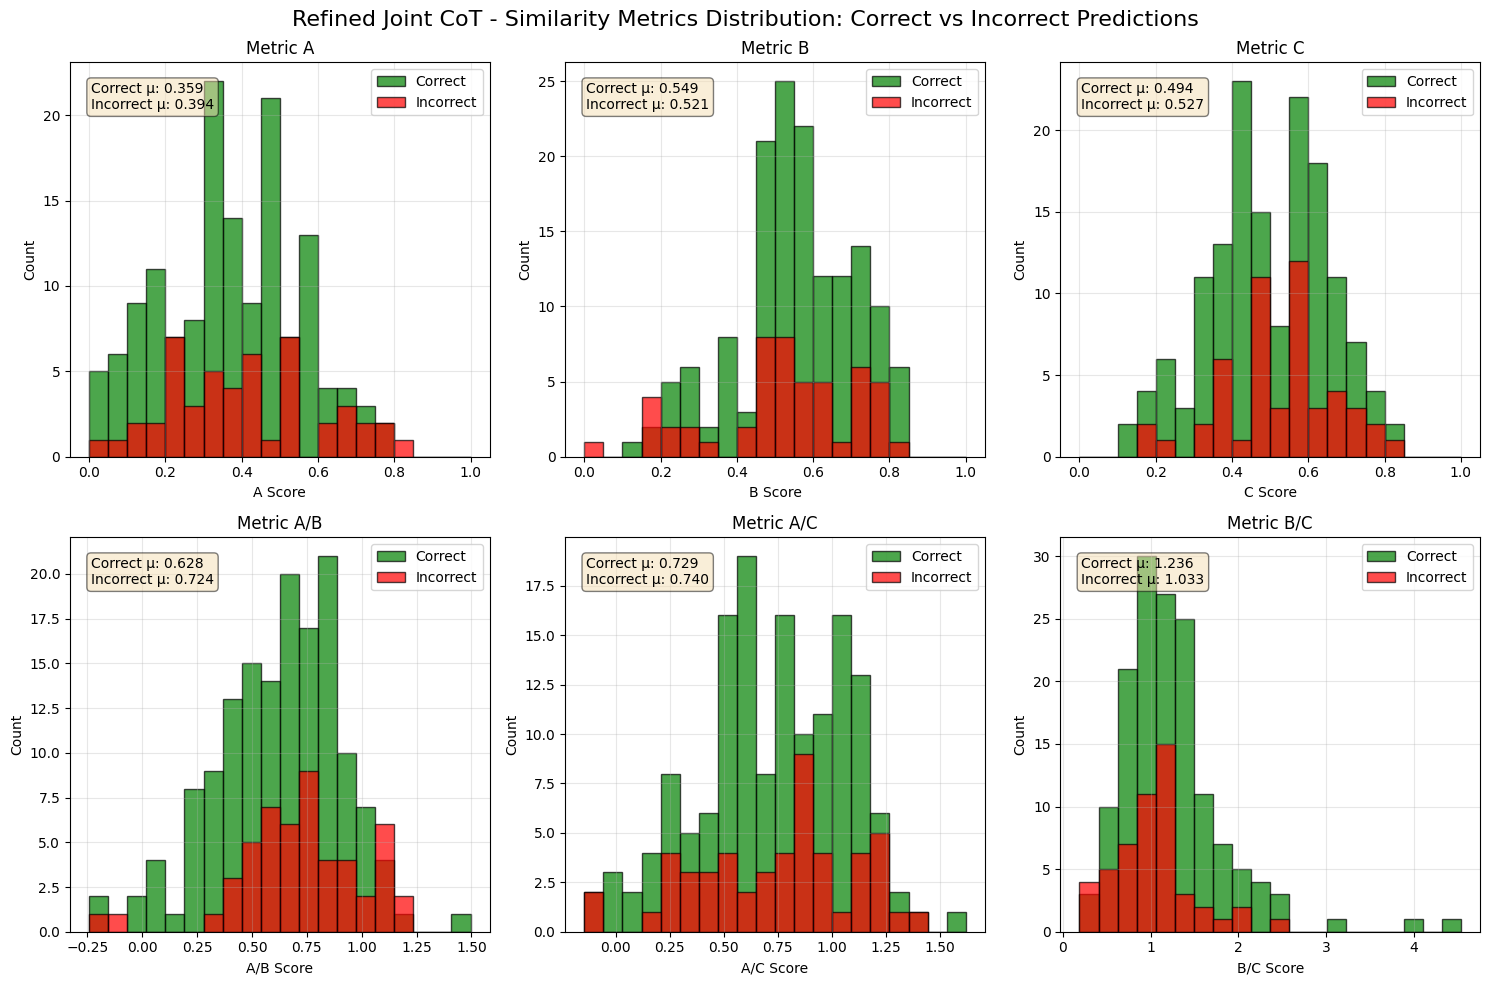

In [18]:
joint_fig = create_similarity_histograms(refined_joint_results, "Refined Joint CoT")
plt.show()

In [19]:
refined_pipeline_accuracy, refined_pipeline_results = evaluate_with_similarity_parallel(
    refined_pipeline,
    dspy_eval_samples[:200],
    num_threads=8,  
    collect_results=True
)
print(f"Refined Pipeline Module Accuracy: {refined_pipeline_accuracy:.3f}")

Average Metric: 147.00 / 200 (73.5%): 100%|██████████| 200/200 [02:41<00:00,  1.24it/s]

2025/08/03 16:42:46 INFO dspy.evaluate.evaluate: Average Metric: 147 / 200 (73.5%)



Refined Pipeline Module Accuracy: 73.500


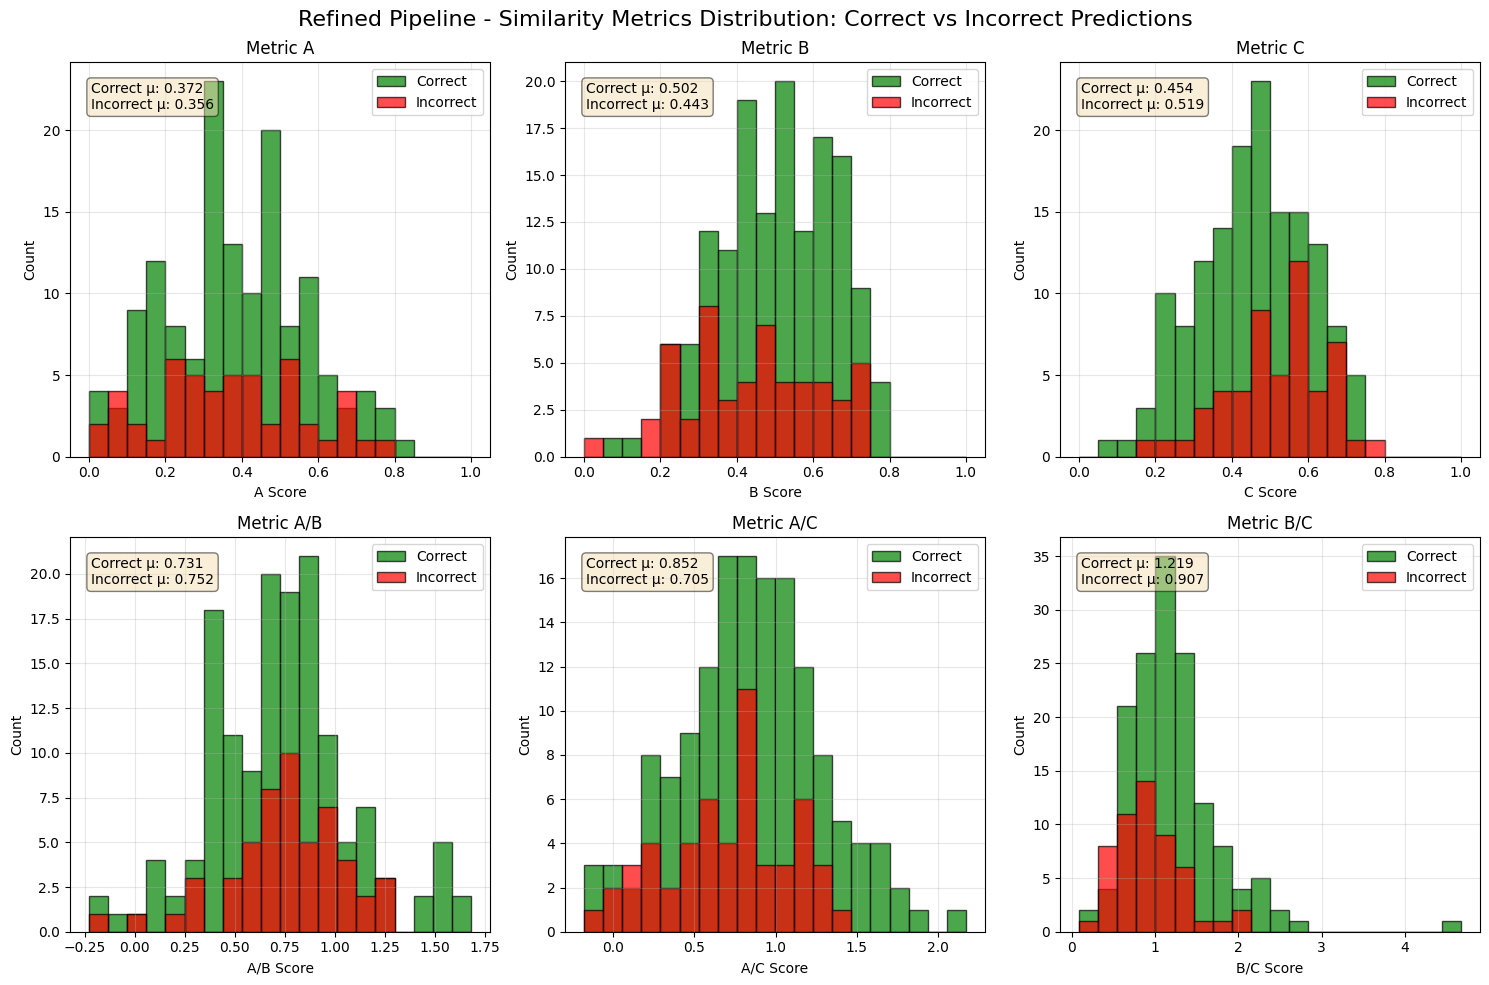

In [20]:
pipeline_fig = create_similarity_histograms(refined_pipeline_results, "Refined Pipeline")
plt.show()

### Refine Module Discussion 

Refined Joint CoT: 

After adding the Refine Module to the Joint CoT Module with the similarity thresholds we found in our analysis, we saw that our accuracy improved from 0.735 to 0.755. 

### Optimize Modules

In [21]:
from dspy import MIPROv2

def exact_match(pred, gold, trace=None):
    try:
        # Create label mappings
        label_names = ["entailment", "neutral", "contradiction"]
        label2id = {label: i for i, label in enumerate(label_names)}
        
        # Extract labels
        pred_label = getattr(pred, 'label', pred)
        gold_label = getattr(gold, 'label', gold)
        
        # Convert pred_label to numeric if it's a string
        if isinstance(pred_label, str):
            pred_label_id = label2id.get(pred_label.strip().lower(), -1)
        else:
            pred_label_id = pred_label
            
        # Convert gold_label to numeric if it's a string
        if isinstance(gold_label, str):
            gold_label_id = label2id.get(gold_label.strip().lower(), -1)
        else:
            gold_label_id = gold_label
            
        return pred_label_id == gold_label_id
        
    except Exception as e:
        print(f"Error in exact_match: {e}, pred={pred_label}, gold={gold_label}")
        return False



In [22]:
optimizer = MIPROv2(metric=exact_match)

### Train Optimizer On Refined Modules

In [23]:
optimized_joint = optimizer.compile(
    refined_joint,
    trainset=dspy_eval_samples[:100],
    requires_permission_to_run=False  
)

2025/08/03 16:42:49 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 10
minibatch: True
num_fewshot_candidates: 6
num_instruct_candidates: 3
valset size: 80

2025/08/03 16:42:49 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/08/03 16:42:49 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/08/03 16:42:49 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=6 sets of demonstrations...


Bootstrapping set 1/6
Bootstrapping set 2/6
Bootstrapping set 3/6


 25%|██▌       | 5/20 [00:02<00:08,  1.80it/s]


Bootstrapped 4 full traces after 5 examples for up to 1 rounds, amounting to 5 attempts.
Bootstrapping set 4/6


 20%|██        | 4/20 [00:02<00:08,  1.87it/s]


Bootstrapped 3 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 5/6


 20%|██        | 4/20 [00:02<00:10,  1.58it/s]


Bootstrapped 2 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 6/6


  5%|▌         | 1/20 [00:02<00:53,  2.79s/it]
2025/08/03 16:43:00 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/08/03 16:43:00 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/08/03 16:43:00 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=3 instructions...

2025/08/03 16:43:00 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/08/03 16:43:00 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Generate both an explanation and a label for the NLI task in one step.

2025/08/03 16:43:00 INFO dspy.teleprompt.mipro_optimizer_v2: 1: For each provided premise and hypothesis from the dataset, which focuses on non-entailment cases (always labeled as 0) involving topics like politics, sports, and crime, generate a clear and detailed explanat

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Error getting source code: unhashable type: 'dict'.

Running without program aware proposer.
Average Metric: 56.00 / 80 (70.0%): 100%|██████████| 80/80 [03:00<00:00,  2.25s/it]

2025/08/03 16:46:01 INFO dspy.evaluate.evaluate: Average Metric: 56 / 80 (70.0%)
2025/08/03 16:46:01 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 70.0



/Users/yuval/University/Semester 6/NLP_w_LLMs/hw2/nlp-with-llms-2025-hw2/.venv/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/08/03 16:46:01 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 13 - Minibatch ==


  0%|          | 0/35 [00:00<?, ?it/s]

2025/08/03 16:46:04 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:04 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:04 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:04 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:04 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:04 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 3.00 / 4 (75.0%):   9%|▊         | 3/35 [00:04<00:58,  1.83s/it] 

2025/08/03 16:46:08 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:08 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 5.00 / 7 (71.4%):  20%|██        | 7/35 [00:08<00:23,  1.18it/s]

2025/08/03 16:46:12 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 6.00 / 9 (66.7%):  23%|██▎       | 8/35 [00:08<00:22,  1.18it/s]

2025/08/03 16:46:12 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:12 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:12 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:12 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:12 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 9.00 / 15 (60.0%):  40%|████      | 14/35 [00:14<00:19,  1.07it/s]

2025/08/03 16:46:18 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:18 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:18 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:18 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 10.00 / 16 (62.5%):  46%|████▌     | 16/35 [00:17<00:16,  1.14it/s]

2025/08/03 16:46:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 10.00 / 17 (58.8%):  49%|████▊     | 17/35 [00:17<00:14,  1.23it/s]

2025/08/03 16:46:22 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:22 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:22 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:22 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:22 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Refine: Attempt failed with temperature 0.5: Both structured output format and JSON mode failed. Please choose a model that supports `response_format` argument. Original error: '0' is not one of ('entailment', 'neutral', 'contradiction')
Average Metric: 12.00 / 19 (63.2%):  54%|█████▍    | 19/35 [00:23<00:23,  1.45s/it]

2025/08/03 16:46:28 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 14.00 / 21 (66.7%):  57%|█████▋    | 20/35 [00:23<00:21,  1.45s/it]

2025/08/03 16:46:28 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 15.00 / 22 (68.2%):  60%|██████    | 21/35 [00:24<00:20,  1.45s/it]

2025/08/03 16:46:28 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 15.00 / 22 (68.2%):  63%|██████▎   | 22/35 [00:24<00:10,  1.29it/s]

2025/08/03 16:46:28 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 18.00 / 26 (69.2%):  71%|███████▏  | 25/35 [00:28<00:09,  1.11it/s]

2025/08/03 16:46:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 19.00 / 27 (70.4%):  74%|███████▍  | 26/35 [00:28<00:06,  1.32it/s]

2025/08/03 16:46:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 22.00 / 30 (73.3%):  83%|████████▎ | 29/35 [00:31<00:04,  1.41it/s]

2025/08/03 16:46:35 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:46:35 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 27.00 / 35 (77.1%): 100%|██████████| 35/35 [00:32<00:00,  1.09it/s]

2025/08/03 16:46:36 INFO dspy.evaluate.evaluate: Average Metric: 27 / 35 (77.1%)


2025/08/03 16:46:36 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/08/03 16:46:36 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14]
2025/08/03 16:46:36 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0]
2025/08/03 16:46:36 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/03 16:46:36 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/03 16:46:36 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 13 - Minibatch ==


Average Metric: 12.00 / 21 (57.1%):  57%|█████▋    | 20/35 [00:45<00:41,  2.78s/it]

2025/08/03 16:47:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 21.00 / 35 (60.0%): 100%|██████████| 35/35 [01:03<00:00,  1.80s/it]

2025/08/03 16:47:40 INFO dspy.evaluate.evaluate: Average Metric: 21 / 35 (60.0%)
2025/08/03 16:47:40 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 60.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/08/03 16:47:40 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 60.0]
2025/08/03 16:47:40 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0]
2025/08/03 16:47:40 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/03 16:47:40 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/03 16:47:40 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 13 - Minibatch ==



  0%|          | 0/35 [00:00<?, ?it/s]

2025/08/03 16:47:41 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:47:41 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:47:41 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:47:41 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:47:44 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 1.00 / 2 (50.0%):   3%|▎         | 1/35 [00:03<02:10,  3.83s/it]

2025/08/03 16:47:45 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:47:45 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:47:45 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:47:45 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 3.00 / 4 (75.0%):   9%|▊         | 3/35 [00:09<01:33,  2.92s/it]

2025/08/03 16:47:50 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 4.00 / 6 (66.7%):  14%|█▍        | 5/35 [00:09<00:43,  1.45s/it]

2025/08/03 16:47:50 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:47:50 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:47:50 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:47:50 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Refine: Attempt failed with temperature 0.5: Both structured output format and JSON mode failed. Please choose a model that supports `response_format` argument. Original error: '0' is not one of ('entailment', 'neutral', 'contradiction')
Average Metric: 6.00 / 9 (66.7%):  26%|██▌       | 9/35 [00:14<00:31,  1.20s/it]

2025/08/03 16:47:56 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 7.00 / 10 (70.0%):  29%|██▊       | 10/35 [00:14<00:23,  1.08it/s]

2025/08/03 16:47:56 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:47:56 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 8.00 / 11 (72.7%):  31%|███▏      | 11/35 [00:15<00:16,  1.42it/s]

2025/08/03 16:47:56 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:48:01 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 9.00 / 12 (75.0%):  34%|███▍      | 12/35 [00:22<00:58,  2.55s/it]

2025/08/03 16:48:03 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:48:03 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:48:03 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:48:03 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:48:03 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:48:03 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 10.00 / 14 (71.4%):  37%|███▋      | 13/35 [00:25<00:57,  2.61s/it]

2025/08/03 16:48:06 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 10.00 / 14 (71.4%):  40%|████      | 14/35 [00:25<00:41,  1.96s/it]

2025/08/03 16:48:06 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 10.00 / 15 (66.7%):  43%|████▎     | 15/35 [00:25<00:28,  1.45s/it]

2025/08/03 16:48:06 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:48:06 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 11.00 / 17 (64.7%):  46%|████▌     | 16/35 [00:28<00:32,  1.71s/it]

2025/08/03 16:48:09 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 11.00 / 17 (64.7%):  49%|████▊     | 17/35 [00:28<00:22,  1.26s/it]

2025/08/03 16:48:09 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 13.00 / 20 (65.0%):  54%|█████▍    | 19/35 [00:28<00:11,  1.40it/s]

2025/08/03 16:48:09 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 14.00 / 21 (66.7%):  57%|█████▋    | 20/35 [00:28<00:10,  1.40it/s]

2025/08/03 16:48:09 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:48:09 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:48:09 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 14.00 / 22 (63.6%):  63%|██████▎   | 22/35 [00:32<00:14,  1.08s/it]

2025/08/03 16:48:13 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 15.00 / 25 (60.0%):  69%|██████▊   | 24/35 [00:32<00:10,  1.09it/s]

2025/08/03 16:48:14 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 15.00 / 25 (60.0%):  71%|███████▏  | 25/35 [00:33<00:06,  1.64it/s]

2025/08/03 16:48:14 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 16.00 / 26 (61.5%):  74%|███████▍  | 26/35 [00:33<00:04,  1.92it/s]

2025/08/03 16:48:14 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:48:14 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:48:14 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:48:18 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 19.00 / 32 (59.4%):  89%|████████▊ | 31/35 [00:40<00:05,  1.26s/it]

2025/08/03 16:48:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:48:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 22.00 / 35 (62.9%): 100%|██████████| 35/35 [00:41<00:00,  1.18s/it]

2025/08/03 16:48:22 INFO dspy.evaluate.evaluate: Average Metric: 22 / 35 (62.9%)
2025/08/03 16:48:22 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5'].
2025/08/03 16:48:22 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 60.0, 62.86]
2025/08/03 16:48:22 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0]
2025/08/03 16:48:22 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/03 16:48:22 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/03 16:48:22 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 13 - Minibatch ==



Average Metric: 4.00 / 6 (66.7%):  14%|█▍        | 5/35 [00:16<01:21,  2.73s/it]

2025/08/03 16:48:40 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Refine: Attempt failed with temperature 0.6666666666666666: Both structured output format and JSON mode failed. Please choose a model that supports `response_format` argument. Original error: '0' is not one of ('entailment', 'neutral', 'contradiction')
Average Metric: 6.00 / 11 (54.5%):  29%|██▊       | 10/35 [00:21<00:30,  1.22s/it]

2025/08/03 16:48:44 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 6.00 / 12 (50.0%):  34%|███▍      | 12/35 [00:26<00:41,  1.82s/it]

2025/08/03 16:48:49 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:48:50 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 13.00 / 22 (59.1%):  60%|██████    | 21/35 [00:36<00:11,  1.24it/s]

2025/08/03 16:49:00 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 18.00 / 31 (58.1%):  89%|████████▊ | 31/35 [00:50<00:02,  1.34it/s]

2025/08/03 16:49:13 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 19.00 / 32 (59.4%):  89%|████████▊ | 31/35 [00:50<00:02,  1.34it/s]

2025/08/03 16:49:13 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 21.00 / 35 (60.0%): 100%|██████████| 35/35 [00:51<00:00,  1.48s/it]

2025/08/03 16:49:14 INFO dspy.evaluate.evaluate: Average Metric: 21 / 35 (60.0%)
2025/08/03 16:49:15 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 60.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/08/03 16:49:15 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 60.0, 62.86, 60.0]
2025/08/03 16:49:15 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0]
2025/08/03 16:49:15 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/03 16:49:15 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/03 16:49:15 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 13 - Minibatch ==



Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [00:41<00:00,  1.19s/it]

2025/08/03 16:49:57 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)


2025/08/03 16:49:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5'].
2025/08/03 16:49:57 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 60.0, 62.86, 60.0, 65.71]
2025/08/03 16:49:57 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0]
2025/08/03 16:49:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/03 16:49:57 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/03 16:49:57 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 13 - Full Evaluation =====
2025/08/03 16:49:57 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 77.14) from minibatch trials...


  0%|          | 0/80 [00:00<?, ?it/s]

2025/08/03 16:49:58 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:49:58 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:49:58 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:49:58 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:49:58 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:49:58 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 1.00 / 2 (50.0%):   2%|▎         | 2/80 [00:05<03:06,  2.39s/it]

2025/08/03 16:50:04 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 2.00 / 3 (66.7%):   2%|▎         | 2/80 [00:05<03:06,  2.39s/it]

2025/08/03 16:50:04 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 2.00 / 3 (66.7%):   4%|▍         | 3/80 [00:05<01:47,  1.40s/it]

2025/08/03 16:50:04 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:50:04 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 3.00 / 4 (75.0%):   5%|▌         | 4/80 [00:09<02:47,  2.20s/it]

2025/08/03 16:50:07 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 4.00 / 5 (80.0%):   5%|▌         | 4/80 [00:09<02:47,  2.20s/it]

2025/08/03 16:50:07 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 4.00 / 5 (80.0%):   6%|▋         | 5/80 [00:09<01:49,  1.47s/it]

2025/08/03 16:50:07 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:50:07 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:50:07 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 6.00 / 7 (85.7%):   8%|▊         | 6/80 [00:13<02:44,  2.22s/it]

2025/08/03 16:50:11 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 6.00 / 7 (85.7%):   9%|▉         | 7/80 [00:13<01:55,  1.58s/it]

2025/08/03 16:50:11 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 6.00 / 9 (66.7%):  11%|█▏        | 9/80 [00:13<00:57,  1.24it/s]

2025/08/03 16:50:12 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:50:12 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 8.00 / 11 (72.7%):  12%|█▎        | 10/80 [00:16<01:33,  1.34s/it]

2025/08/03 16:50:14 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 8.00 / 11 (72.7%):  14%|█▍        | 11/80 [00:16<01:07,  1.02it/s]

2025/08/03 16:50:14 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:50:14 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 9.00 / 13 (69.2%):  16%|█▋        | 13/80 [00:16<00:37,  1.79it/s]

2025/08/03 16:50:15 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:50:15 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 10.00 / 14 (71.4%):  18%|█▊        | 14/80 [00:20<01:43,  1.56s/it]

2025/08/03 16:50:22 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 12.00 / 18 (66.7%):  22%|██▎       | 18/80 [00:23<00:57,  1.08it/s]

2025/08/03 16:50:22 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 12.00 / 19 (63.2%):  24%|██▍       | 19/80 [00:26<01:23,  1.38s/it]

2025/08/03 16:50:25 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 13.00 / 21 (61.9%):  25%|██▌       | 20/80 [00:27<01:07,  1.12s/it]

2025/08/03 16:50:25 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:50:25 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 14.00 / 22 (63.6%):  26%|██▋       | 21/80 [00:27<00:51,  1.13it/s]

2025/08/03 16:50:25 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 14.00 / 23 (60.9%):  28%|██▊       | 22/80 [00:27<00:39,  1.46it/s]

2025/08/03 16:50:25 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 15.00 / 25 (60.0%):  30%|███       | 24/80 [00:31<01:24,  1.51s/it]

2025/08/03 16:50:30 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 15.00 / 25 (60.0%):  31%|███▏      | 25/80 [00:31<01:02,  1.14s/it]

2025/08/03 16:50:30 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:50:30 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:50:30 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 16.00 / 26 (61.5%):  32%|███▎      | 26/80 [00:34<01:34,  1.74s/it]

2025/08/03 16:50:34 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:50:34 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 17.00 / 27 (63.0%):  34%|███▍      | 27/80 [00:36<01:24,  1.60s/it]

2025/08/03 16:50:34 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:50:38 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 19.00 / 30 (63.3%):  38%|███▊      | 30/80 [00:40<01:05,  1.32s/it]

2025/08/03 16:50:39 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 20.00 / 31 (64.5%):  38%|███▊      | 30/80 [00:41<01:05,  1.32s/it]

2025/08/03 16:50:39 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 21.00 / 33 (63.6%):  41%|████▏     | 33/80 [00:41<00:33,  1.41it/s]

2025/08/03 16:50:40 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 21.00 / 35 (60.0%):  44%|████▍     | 35/80 [00:43<00:32,  1.37it/s]

2025/08/03 16:50:41 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 22.00 / 36 (61.1%):  44%|████▍     | 35/80 [00:43<00:32,  1.37it/s]

2025/08/03 16:50:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 22.00 / 36 (61.1%):  45%|████▌     | 36/80 [00:43<00:26,  1.65it/s]

2025/08/03 16:50:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 23.00 / 39 (59.0%):  49%|████▉     | 39/80 [00:47<00:41,  1.01s/it]

2025/08/03 16:50:45 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 25.00 / 41 (61.0%):  50%|█████     | 40/80 [00:50<00:33,  1.19it/s]

2025/08/03 16:50:49 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 25.00 / 41 (61.0%):  51%|█████▏    | 41/80 [00:50<00:56,  1.44s/it]

2025/08/03 16:50:49 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:50:49 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:50:49 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:50:52 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Refine: Attempt failed with temperature 0.5: Both structured output format and JSON mode failed. Please choose a model that supports `response_format` argument. Original error: 0 is not one of ('entailment', 'neutral', 'contradiction')
Average Metric: 27.00 / 44 (61.4%):  55%|█████▌    | 44/80 [00:56<00:54,  1.52s/it]

2025/08/03 16:50:55 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 27.00 / 45 (60.0%):  55%|█████▌    | 44/80 [00:56<00:54,  1.52s/it]

2025/08/03 16:50:55 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 27.00 / 45 (60.0%):  56%|█████▋    | 45/80 [00:57<00:40,  1.16s/it]

2025/08/03 16:50:55 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 27.00 / 46 (58.7%):  56%|█████▋    | 45/80 [00:57<00:40,  1.16s/it]

2025/08/03 16:50:55 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 27.00 / 48 (56.2%):  60%|██████    | 48/80 [00:57<00:21,  1.52it/s]

2025/08/03 16:50:56 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 28.00 / 49 (57.1%):  61%|██████▏   | 49/80 [01:00<00:35,  1.14s/it]

2025/08/03 16:50:59 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 28.00 / 50 (56.0%):  61%|██████▏   | 49/80 [01:00<00:35,  1.14s/it]

2025/08/03 16:50:59 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 29.00 / 51 (56.9%):  64%|██████▍   | 51/80 [01:01<00:22,  1.30it/s]

2025/08/03 16:50:59 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 32.00 / 54 (59.3%):  68%|██████▊   | 54/80 [01:06<00:29,  1.13s/it]

2025/08/03 16:51:05 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 33.00 / 55 (60.0%):  68%|██████▊   | 54/80 [01:06<00:29,  1.13s/it]

2025/08/03 16:51:05 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 33.00 / 56 (58.9%):  69%|██████▉   | 55/80 [01:06<00:23,  1.08it/s]

2025/08/03 16:51:05 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 36.00 / 60 (60.0%):  75%|███████▌  | 60/80 [01:11<00:15,  1.31it/s]

2025/08/03 16:51:13 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:51:14 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:51:18 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:51:20 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 36.00 / 61 (59.0%):  76%|███████▋  | 61/80 [01:22<01:05,  3.43s/it]

2025/08/03 16:51:20 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 39.00 / 64 (60.9%):  80%|████████  | 64/80 [01:22<00:23,  1.48s/it]

2025/08/03 16:51:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 39.00 / 65 (60.0%):  81%|████████▏ | 65/80 [01:23<00:19,  1.29s/it]

2025/08/03 16:51:22 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 40.00 / 66 (60.6%):  82%|████████▎ | 66/80 [01:25<00:20,  1.48s/it]

2025/08/03 16:51:24 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 40.00 / 67 (59.7%):  84%|████████▍ | 67/80 [01:25<00:15,  1.18s/it]

2025/08/03 16:51:24 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 41.00 / 68 (60.3%):  85%|████████▌ | 68/80 [01:26<00:11,  1.03it/s]

2025/08/03 16:51:25 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:51:27 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 42.00 / 70 (60.0%):  88%|████████▊ | 70/80 [01:29<00:12,  1.21s/it]

2025/08/03 16:51:28 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:51:28 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:51:30 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 42.00 / 71 (59.2%):  89%|████████▉ | 71/80 [01:31<00:12,  1.43s/it]

2025/08/03 16:51:30 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:51:30 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 43.00 / 72 (59.7%):  90%|█████████ | 72/80 [01:32<00:08,  1.12s/it]

2025/08/03 16:51:30 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 47.00 / 78 (60.3%):  96%|█████████▋| 77/80 [01:33<00:01,  1.97it/s]

2025/08/03 16:51:31 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 49.00 / 80 (61.2%): 100%|██████████| 80/80 [01:33<00:00,  1.17s/it]

2025/08/03 16:51:31 INFO dspy.evaluate.evaluate: Average Metric: 49 / 80 (61.2%)
2025/08/03 16:51:31 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0, 61.25]
2025/08/03 16:51:31 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/03 16:51:31 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/03 16:51:31 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/03 16:51:31 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 8 / 13 - Minibatch ==



Average Metric: 19.00 / 35 (54.3%): 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]

2025/08/03 16:52:19 INFO dspy.evaluate.evaluate: Average Metric: 19 / 35 (54.3%)
2025/08/03 16:52:20 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 54.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/08/03 16:52:20 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 60.0, 62.86, 60.0, 65.71, 54.29]
2025/08/03 16:52:20 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0, 61.25]
2025/08/03 16:52:20 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/03 16:52:20 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/03 16:52:20 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 13 - Minibatch ==



Average Metric: 1.00 / 4 (25.0%):  11%|█▏        | 4/35 [00:11<01:18,  2.52s/it]

2025/08/03 16:52:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:52:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:52:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 4.00 / 10 (40.0%):  29%|██▊       | 10/35 [00:18<00:20,  1.20it/s]

2025/08/03 16:52:39 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 8.00 / 14 (57.1%):  40%|████      | 14/35 [00:28<00:28,  1.37s/it]

2025/08/03 16:52:49 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:52:49 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:52:49 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 10.00 / 18 (55.6%):  51%|█████▏    | 18/35 [00:31<00:14,  1.21it/s]

2025/08/03 16:52:52 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:52:52 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 12.00 / 20 (60.0%):  54%|█████▍    | 19/35 [00:38<00:41,  2.57s/it]

2025/08/03 16:52:59 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 15.00 / 23 (65.2%):  66%|██████▌   | 23/35 [00:43<00:19,  1.62s/it]

2025/08/03 16:53:05 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/03 16:53:08 WARNING dspy.utils.parallelizer: SIGINT received. Cancelling.
[W 2025-08-03 16:53:08,984] Trial 8 failed with parameters: {'0_predictor_instruction': 2, '0_predictor_demos': 5} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/yuval/University/Semester 6/NLP_w_LLMs/hw2/nlp-with-llms-2025-hw2/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/Users/yuval/University/Semester 6/NLP_w_LLMs/hw2/nlp-with-llms-2025-hw2/.venv/lib/python3.11/site-packages/dspy/teleprompt/mipro_optimizer_v2.py", line 565, in objective
    score = eval_candidate_program(batch_size, valset, candidate_program, evaluate, self.rng)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

### Evaluate Optimized Modules

In [ ]:
print("Evaluating optimized model...")
opt_accuracy, opt_results = evaluate_with_similarity_parallel(
    optimized_joint,
    dspy_eval_samples[100:300],  # Use different data for testing
    num_threads=4,
    collect_results=True
)
print(f"Optimized Joint CoT Accuracy: {opt_accuracy:.3f}")

# Visualize results
opt_fig = create_similarity_histograms(opt_results, "Optimized Joint CoT")
plt.show()

### Optimized Pipeline Functions that need to be completed 

In [ ]:
# optimized_pipeline = optimizer.compile(
#     refined_pipeline,
#     trainset=dspy_eval_samples[:100],
#     requires_permission_to_run=False  
# )